In [1]:
# import libraries for reading data, exploring and plotting
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
# library for train test split
from sklearn.model_selection import train_test_split

# deep learning libraries for text pre-processing
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences# Modeling 
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, GlobalAveragePooling1D, Dense, Dropout, LSTM, Bidirectional

import chardet
import warnings
warnings.filterwarnings("ignore")

In [2]:
import pandas as pd

messages = pd.read_csv(
    r"D:\AICTE Internship\spammsg.csv",  
    encoding="ISO-8859-1"
)

print(messages.head(3))

     v1                                                 v2 Unnamed: 2  \
0   ham  Go until jurong point, crazy.. Available only ...        NaN   
1   ham                      Ok lar... Joking wif u oni...        NaN   
2  spam  Free entry in 2 a wkly comp to win FA Cup fina...        NaN   

  Unnamed: 3 Unnamed: 4  
0        NaN        NaN  
1        NaN        NaN  
2        NaN        NaN  


In [3]:
# Importing Data---Just another way of reading the file

# Detect the encoding of the file
with open(r'D:\AICTE Internship\spammsg.csv', 'rb') as f:
    result = chardet.detect(f.read())
    
# Read the file using the detected encoding
df = pd.read_csv(r'D:\AICTE Internship\spammsg.csv', encoding=result['encoding'])
df

# Dmessages.groupby('label').describe().Tisplaying the statistics 
messages.describe()

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
count,5572,5572,50,12,6
unique,2,5169,43,10,5
top,ham,"Sorry, I'll call later","bt not his girlfrnd... G o o d n i g h t . . .@""","MK17 92H. 450Ppw 16""","GNT:-)"""
freq,4825,30,3,2,2


In [4]:
# Drop irrelevant columns
messages = messages.drop(['Unnamed: 2', 'Unnamed: 3', 'Unnamed: 4'], axis=1)

In [5]:
messages.shape

(5572, 2)

In [6]:
messages.isnull().sum()

v1    0
v2    0
dtype: int64

In [7]:
# To display the duplicate rows
duplicatedRow = messages[messages.duplicated()]
print(duplicatedRow[:5])

      v1                                                 v2
102  ham  As per your request 'Melle Melle (Oru Minnamin...
153  ham  As per your request 'Melle Melle (Oru Minnamin...
206  ham  As I entered my cabin my PA said, '' Happy B'd...
222  ham                             Sorry, I'll call later
325  ham                   No calls..messages..missed calls


In [8]:
# Rename Columns
messages = messages.rename(columns={'v1': 'label', 'v2': 'message'})
messages.head(2)

,label,message
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...


In [9]:
#To check whether data is balanced or not
messages.groupby('label').describe().T

label                              ham  \
message count                     4825   
        unique                    4516   
        top     Sorry, I'll call later   
        freq                        30   

label                                                        spam  
message count                                                 747  
        unique                                                653  
        top     Please call our customer service representativ...  
        freq                                                    4

In [10]:
# Get all the ham and spam emails
ham_msg = messages[messages.label =='ham']
spam_msg = messages[messages.label=='spam']# Create numpy list to visualize using wordcloud
ham_msg_text = " ".join(ham_msg.message.to_numpy().tolist())
spam_msg_text = " ".join(spam_msg.message.to_numpy().tolist())

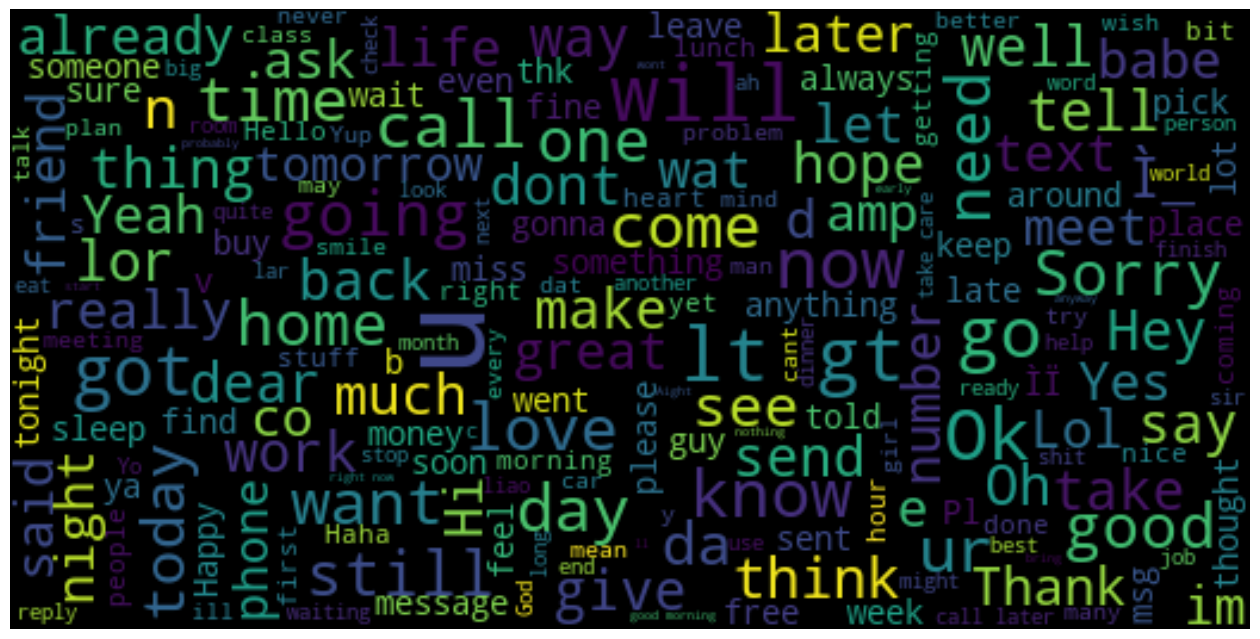

In [11]:
# wordcloud of ham messages
ham_msg_cloud = WordCloud(width =520, height =260, stopwords=STOPWORDS,max_font_size=50, background_color ="black").generate(ham_msg_text)
plt.figure(figsize=(16,10))
plt.imshow(ham_msg_cloud, interpolation='bilinear')
plt.axis('off') # turn off axis
plt.show()

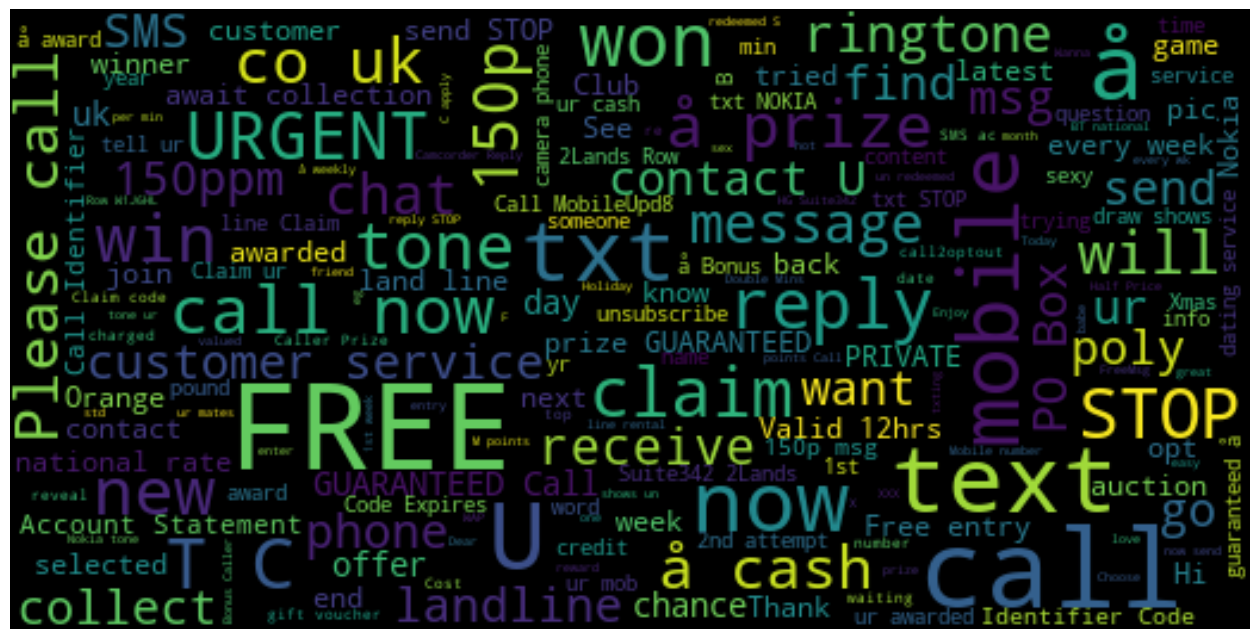

In [12]:
# wordcloud of spam messages
spam_msg_cloud = WordCloud(width =520, height =260, stopwords=STOPWORDS,max_font_size=50, background_color ="black").generate(spam_msg_text)
plt.figure(figsize=(16,10))
plt.imshow(spam_msg_cloud, interpolation='bilinear')
plt.axis('off') # turn off axis
plt.show()

15.481865284974095

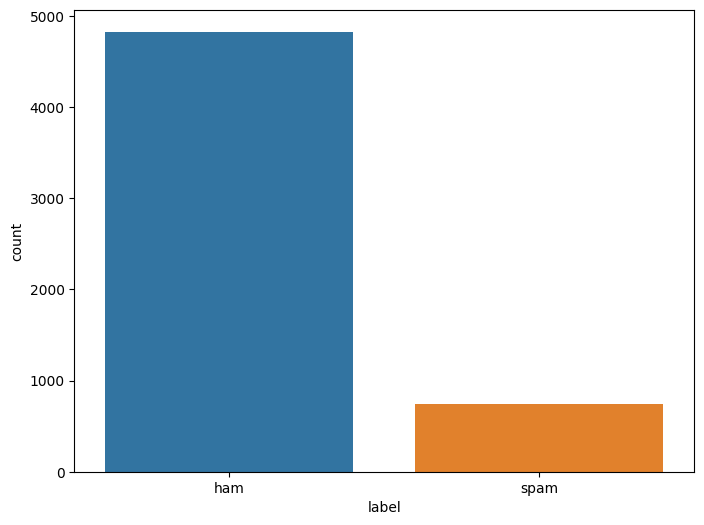

In [13]:
# we can observe imbalance data here 
plt.figure(figsize=(8,6))
sns.countplot(x=messages.label,data=messages)
# Percentage of spam messages
(len(spam_msg)/len(ham_msg))*100 # 15.48%

In [14]:
# one way to fix it is to downsample the ham msg
ham_msg_df = ham_msg.sample(n = len(spam_msg), random_state = 44)
spam_msg_df = spam_msg
print(ham_msg_df.shape, spam_msg_df.shape)

(747, 2) (747, 2)


Text(0.5, 0, 'Message types')

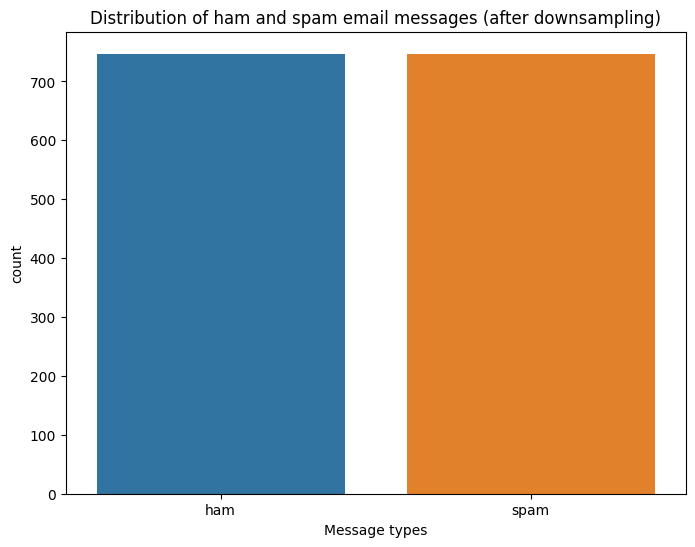

In [15]:
# Create a dataframe with these ham and spam msg
msg_df = pd.concat([ham_msg_df, spam_msg_df], ignore_index=True)
plt.figure(figsize=(8,6))
sns.countplot(x=msg_df.label)
plt.title('Distribution of ham and spam email messages (after downsampling)')
plt.xlabel('Message types')

In [16]:
# Get length column for each text
msg_df['text_length'] = msg_df['message'].apply(len)

# Group by 'label' and calculate mean text length
labels = msg_df.groupby('label')['text_length'].mean()
print(labels)

label
ham      69.626506
spam    138.866131
Name: text_length, dtype: float64


In [17]:
# Map ham label as 0 and spam as 1
msg_df['msg_type']= msg_df['label'].map({'ham': 0, 'spam': 1})
msg_label = msg_df['msg_type'].values
# Split data into train and test
train_msg, test_msg, train_labels, test_labels = train_test_split(msg_df['message'], msg_label, test_size=0.2, random_state=434)

In [18]:
# Defining pre-processing hyperparameters
max_len = 50 
trunc_type = "post" 
padding_type = "post" 
oov_tok = "<OOV>" 
vocab_size = 500

In [19]:
tokenizer = Tokenizer(num_words = vocab_size, char_level=False, oov_token = oov_tok)
tokenizer.fit_on_texts(train_msg)
# Get the word_index 
word_index = tokenizer.word_index
word_index

{'<OOV>': 1,
 'to': 2,
 'you': 3,
 'a': 4,
 'i': 5,
 'call': 6,
 'the': 7,
 'your': 8,
 'u': 9,
 'for': 10,
 'now': 11,
 'is': 12,
 '2': 13,
 'and': 14,
 'free': 15,
 'in': 16,
 'or': 17,
 'have': 18,
 'on': 19,
 'ur': 20,
 'of': 21,
 'txt': 22,
 'with': 23,
 'are': 24,
 '4': 25,
 'from': 26,
 'me': 27,
 'text': 28,
 'get': 29,
 'stop': 30,
 'mobile': 31,
 'my': 32,
 'this': 33,
 'be': 34,
 'just': 35,
 'claim': 36,
 'only': 37,
 'it': 38,
 'reply': 39,
 'that': 40,
 'www': 41,
 'no': 42,
 'out': 43,
 'will': 44,
 'at': 45,
 'we': 46,
 'do': 47,
 'so': 48,
 'send': 49,
 'our': 50,
 'not': 51,
 'prize': 52,
 'new': 53,
 'if': 54,
 'cash': 55,
 'but': 56,
 'go': 57,
 'can': 58,
 '150p': 59,
 'up': 60,
 'uk': 61,
 "i'm": 62,
 'please': 63,
 'nokia': 64,
 'who': 65,
 'win': 66,
 't': 67,
 'won': 68,
 '1': 69,
 'all': 70,
 'tone': 71,
 'what': 72,
 'week': 73,
 'com': 74,
 'been': 75,
 'msg': 76,
 'want': 77,
 'phone': 78,
 'know': 79,
 '50': 80,
 'service': 81,
 'by': 82,
 'urgent': 83,
 '

In [20]:
# check how many words 
tot_words = len(word_index)
print('There are %s unique tokens in training data. ' % tot_words)

There are 4054 unique tokens in training data. 


In [21]:
# Sequencing and padding on training and testing 
training_sequences = tokenizer.texts_to_sequences(train_msg)
training_padded = pad_sequences (training_sequences, maxlen = max_len, padding = padding_type, truncating = trunc_type )
testing_sequences = tokenizer.texts_to_sequences(test_msg)
testing_padded = pad_sequences(testing_sequences, maxlen = max_len,padding = padding_type, truncating = trunc_type)

In [22]:
# Shape of train tensor
print('Shape of training tensor: ', training_padded.shape)
print('Shape of testing tensor: ', testing_padded.shape)

Shape of training tensor:  (1195, 50)
Shape of testing tensor:  (299, 50)


In [23]:
# Before padding length
print(len(training_sequences[0]), len(training_sequences[1]))
# After padding length
print(len(training_padded[0]), len(training_padded[1]))

27 24
50 50


In [24]:
vocab_size = 500 # As defined earlier
embeding_dim = 16
drop_value = 0.2 # dropout
n_dense = 24
#Dense model architecture
model = Sequential()
model.add(Embedding(vocab_size, embeding_dim, input_length=max_len))
model.add(GlobalAveragePooling1D())
model.add(Dense(24, activation='relu'))
model.add(Dropout(drop_value))
model.add(Dense(1, activation='sigmoid'))
model.summary()
model.compile(loss='binary_crossentropy',optimizer='adam' ,metrics=['accuracy'])

# fitting a dense spam detector model
num_epochs = 50
early_stop = EarlyStopping(monitor='val_loss', patience=3)
history = model.fit(training_padded, train_labels, epochs=num_epochs, validation_data=(testing_padded, test_labels),callbacks =[early_stop], verbose=2)
model.save('Dense_Spam_Detection.keras')

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding (Embedding)                │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling1d             │ ?                           │               0 │
│ (GlobalAveragePooling1D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ ?                           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
38/38 - 2s - 50ms/step - accuracy: 0.5406 - loss: 0.6764 - val_accuracy: 0.5318 - val_loss: 0.6563
Epoch 2/50
38/38 - 0s - 3ms/step - accuracy: 0.6636 - loss: 0.6295 - val_accuracy: 0.7057 - val_loss: 0.6032
Epoch 3/50
38/38 - 0s - 3ms/step - accuracy: 0.8000 - loss: 0.5546 - val_accuracy: 0.7993 - val_loss: 0.5348
Epoch 4/50
38/38 - 0s - 3ms/step - accuracy: 0.8510 - loss: 0.4722 - val_accuracy: 0.8127 - val_loss: 0.4737
Epoch 5/50
38/38 - 0s - 4ms/step - accuracy: 0.8519 - loss: 0.4188 - val_accuracy: 0.8328 - val_loss: 0.4307
Epoch 6/50
38/38 - 0s - 4ms/step - accuracy: 0.8745 - loss: 0.3590 - val_accuracy: 0.8395 - val_loss: 0.3791
Epoch 7/50
38/38 - 0s - 4ms/step - accuracy: 0.8879 - loss: 0.3195 - val_accuracy: 0.8528 - val_loss: 0.3338
Epoch 8/50
38/38 - 0s - 4ms/step - accuracy: 0.8954 - loss: 0.2816 - val_accuracy: 0.8696 - val_loss: 0.2974
Epoch 9/50
38/38 - 0s - 3ms/step - accuracy: 0.9163 - loss: 0.2467 - val_accuracy: 0.9130 - val_loss: 0.2474
Epoch 10/50
38/38 

In [25]:
vocab_size = 500 # As defined earlier
embeding_dim = 16
drop_value = 0.2 # dropout
n_dense = 24
#Dense model architecture
model = Sequential()
model.add(Embedding(vocab_size, embeding_dim, input_length=max_len))
model.add(GlobalAveragePooling1D())
model.add(Dense(24, activation='relu'))
model.add(Dropout(drop_value))
model.add(Dense(1, activation='sigmoid'))
model.summary()
model.compile(loss='binary_crossentropy',optimizer='adam' ,metrics=['accuracy'])

# fitting a dense spam detector model
num_epochs = 50
early_stop = EarlyStopping(monitor='val_loss', patience=3)
history = model.fit(training_padded, train_labels, epochs=num_epochs, validation_data=(testing_padded, test_labels),callbacks =[early_stop], verbose=2)
model.save('Dense_Spam_Detection.h5')

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_1 (Embedding)              │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling1d_1           │ ?                           │               0 │
│ (GlobalAveragePooling1D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ ?                           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
38/38 - 1s - 39ms/step - accuracy: 0.5213 - loss: 0.6727 - val_accuracy: 0.5518 - val_loss: 0.6437
Epoch 2/50
38/38 - 0s - 3ms/step - accuracy: 0.6628 - loss: 0.6108 - val_accuracy: 0.7157 - val_loss: 0.5865
Epoch 3/50
38/38 - 0s - 3ms/step - accuracy: 0.8000 - loss: 0.5384 - val_accuracy: 0.7793 - val_loss: 0.5229
Epoch 4/50
38/38 - 0s - 4ms/step - accuracy: 0.8385 - loss: 0.4722 - val_accuracy: 0.8194 - val_loss: 0.4687
Epoch 5/50
38/38 - 0s - 3ms/step - accuracy: 0.8527 - loss: 0.4143 - val_accuracy: 0.8328 - val_loss: 0.4341
Epoch 6/50
38/38 - 0s - 3ms/step - accuracy: 0.8669 - loss: 0.3777 - val_accuracy: 0.8395 - val_loss: 0.3834
Epoch 7/50
38/38 - 0s - 3ms/step - accuracy: 0.8845 - loss: 0.3322 - val_accuracy: 0.8528 - val_loss: 0.3405
Epoch 8/50
38/38 - 0s - 4ms/step - accuracy: 0.8971 - loss: 0.2930 - val_accuracy: 0.8763 - val_loss: 0.3009
Epoch 9/50
38/38 - 0s - 3ms/step - accuracy: 0.9054 - loss: 0.2657 - val_accuracy: 0.8997 - val_loss: 0.2647
Epoch 10/50
38/38 

In [26]:
# Model performance on test data 
model.evaluate(testing_padded, test_labels)
# Read as a dataframe 
metrics = pd.DataFrame(history.history)
# Rename column
metrics.rename(columns = {'loss': 'Training_Loss', 'accuracy': 'Training_Accuracy', 'val_loss': 'Validation_Loss', 'val_accuracy': 'Validation_Accuracy'}, inplace = True)

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9553 - loss: 0.1050 


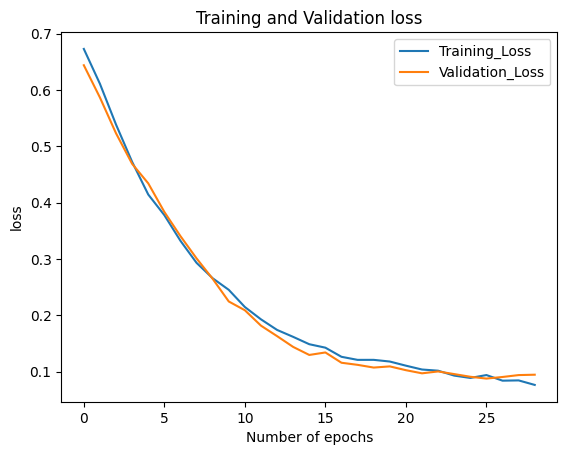

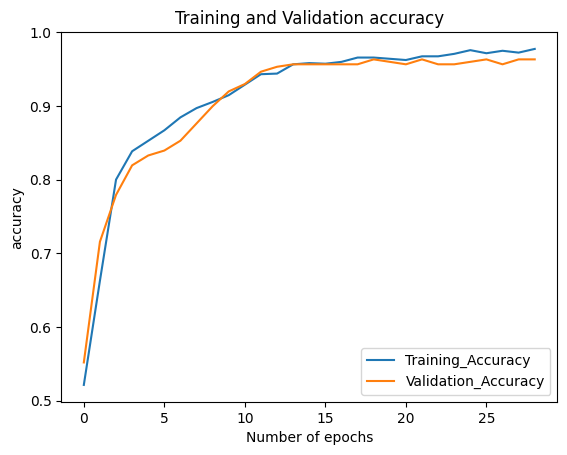

In [27]:
def plot_graphs1(var1, var2, string):
    metrics[[var1, var2]].plot()
    plt.title('Training and Validation ' + string)
    plt.xlabel ('Number of epochs')
    plt.ylabel(string)
    plt.legend([var1, var2])
plot_graphs1('Training_Loss', 'Validation_Loss', 'loss')
plot_graphs1('Training_Accuracy', 'Validation_Accuracy', 'accuracy')

In [28]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense
from tensorflow.keras.callbacks import EarlyStopping

# LSTM Hyperparameters
n_lstm = 20
drop_lstm = 0.2

# LSTM Spam Detection Model
model1 = Sequential()
model1.add(Embedding(vocab_size, embeding_dim, input_length=max_len))
model1.add(LSTM(n_lstm, dropout=drop_lstm))  # Keep return_sequences=False
model1.add(Dense(1, activation='sigmoid'))

# Compile Model
model1.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# Training Setup
num_epochs = 30
early_stop = EarlyStopping(monitor='val_loss', patience=5)

# Train the Model
history = model1.fit(training_padded, train_labels, 
                     epochs=num_epochs, 
                     validation_data=(testing_padded, test_labels), 
                     callbacks=[early_stop], verbose=2)

# Save Model in Recommended Format
model1.save('LSTM_Spam_Detection.keras') 

Epoch 1/30
38/38 - 3s - 76ms/step - accuracy: 0.4954 - loss: 0.6936 - val_accuracy: 0.4816 - val_loss: 0.6912
Epoch 2/30
38/38 - 0s - 9ms/step - accuracy: 0.7414 - loss: 0.5911 - val_accuracy: 0.8796 - val_loss: 0.3668
Epoch 3/30
38/38 - 0s - 10ms/step - accuracy: 0.8912 - loss: 0.3282 - val_accuracy: 0.9130 - val_loss: 0.2760
Epoch 4/30
38/38 - 0s - 9ms/step - accuracy: 0.9322 - loss: 0.2239 - val_accuracy: 0.9799 - val_loss: 0.1274
Epoch 5/30
38/38 - 0s - 10ms/step - accuracy: 0.9582 - loss: 0.1630 - val_accuracy: 0.9666 - val_loss: 0.1359
Epoch 6/30
38/38 - 0s - 10ms/step - accuracy: 0.9623 - loss: 0.1451 - val_accuracy: 0.9599 - val_loss: 0.1375
Epoch 7/30
38/38 - 0s - 10ms/step - accuracy: 0.9707 - loss: 0.1164 - val_accuracy: 0.9599 - val_loss: 0.1510
Epoch 8/30
38/38 - 0s - 12ms/step - accuracy: 0.9623 - loss: 0.1285 - val_accuracy: 0.9799 - val_loss: 0.0828
Epoch 9/30
38/38 - 0s - 10ms/step - accuracy: 0.9732 - loss: 0.1018 - val_accuracy: 0.9766 - val_loss: 0.0887
Epoch 10/30


In [29]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense
from tensorflow.keras.callbacks import EarlyStopping

# LSTM Hyperparameters
n_lstm = 20
drop_lstm = 0.2

# LSTM Spam Detection Model
model1 = Sequential()
model1.add(Embedding(vocab_size, embeding_dim, input_length=max_len))
model1.add(LSTM(n_lstm, dropout=drop_lstm))  # Keep return_sequences=False
model1.add(Dense(1, activation='sigmoid'))

# Compile Model
model1.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# Training Setup
num_epochs = 30
early_stop = EarlyStopping(monitor='val_loss', patience=5)

# Train the Model
history = model1.fit(training_padded, train_labels, 
                     epochs=num_epochs, 
                     validation_data=(testing_padded, test_labels), 
                     callbacks=[early_stop], verbose=2)

# Save Model in Recommended Format
model1.save('LSTM_Spam_Detection.h5') 

Epoch 1/30
38/38 - 3s - 72ms/step - accuracy: 0.5054 - loss: 0.6932 - val_accuracy: 0.4749 - val_loss: 0.6939
Epoch 2/30
38/38 - 0s - 10ms/step - accuracy: 0.5724 - loss: 0.6737 - val_accuracy: 0.7592 - val_loss: 0.5847
Epoch 3/30
38/38 - 0s - 10ms/step - accuracy: 0.8845 - loss: 0.3826 - val_accuracy: 0.8963 - val_loss: 0.3061
Epoch 4/30
38/38 - 0s - 10ms/step - accuracy: 0.9322 - loss: 0.2347 - val_accuracy: 0.9365 - val_loss: 0.2129
Epoch 5/30
38/38 - 0s - 10ms/step - accuracy: 0.9205 - loss: 0.2399 - val_accuracy: 0.9331 - val_loss: 0.2186
Epoch 6/30
38/38 - 0s - 11ms/step - accuracy: 0.9506 - loss: 0.1869 - val_accuracy: 0.9565 - val_loss: 0.1819
Epoch 7/30
38/38 - 0s - 11ms/step - accuracy: 0.9573 - loss: 0.1742 - val_accuracy: 0.9632 - val_loss: 0.1485
Epoch 8/30
38/38 - 0s - 10ms/step - accuracy: 0.9523 - loss: 0.1774 - val_accuracy: 0.9632 - val_loss: 0.1958
Epoch 9/30
38/38 - 0s - 11ms/step - accuracy: 0.9556 - loss: 0.1804 - val_accuracy: 0.9465 - val_loss: 0.1720
Epoch 10/3

In [30]:
model1.evaluate(testing_padded, test_labels)

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9627 - loss: 0.1533 


[0.19775059819221497, 0.95652174949646]

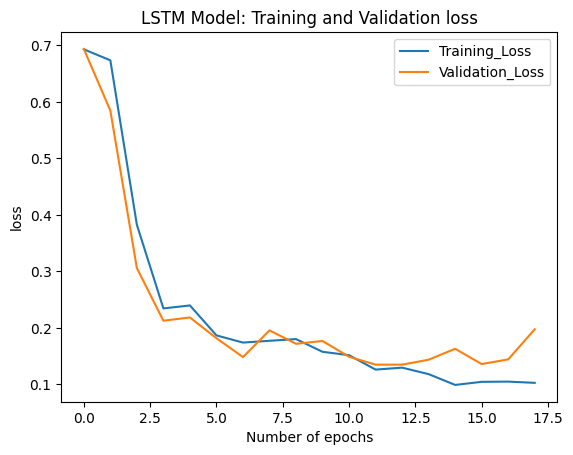

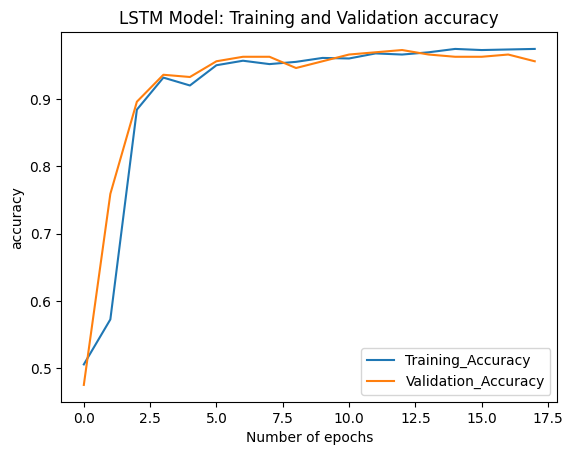

In [31]:
# Create a dataframe
metrics = pd.DataFrame(history.history)# Rename column
metrics.rename(columns = {'loss': 'Training_Loss', 'accuracy': 'Training_Accuracy',
                         'val_loss': 'Validation_Loss', 'val_accuracy': 'Validation_Accuracy'}, inplace = True)
def plot_graphs1(var1, var2, string):
    metrics[[var1, var2]].plot()
    plt.title('LSTM Model: Training and Validation ' + string)
    plt.xlabel ('Number of epochs')
    plt.ylabel(string)
    plt.legend([var1, var2])
plot_graphs1('Training_Loss', 'Validation_Loss', 'loss')
plot_graphs1('Training_Accuracy', 'Validation_Accuracy', 'accuracy')

In [32]:
from sklearn.svm import SVC

# SVC hyperparameters
C = 10
gamma = 0.1
kernel = 'rbf'

# SVM Spam detection
svm_model = SVC(C=C, gamma=gamma, kernel=kernel)
svm_model.fit(training_padded, train_labels)
score = svm_model.score(testing_padded, test_labels)

print("Accuracy:", score)

Accuracy: 0.6956521739130435


In [33]:
model1.evaluate(testing_padded, test_labels)

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9627 - loss: 0.1533 


[0.19775059819221497, 0.95652174949646]

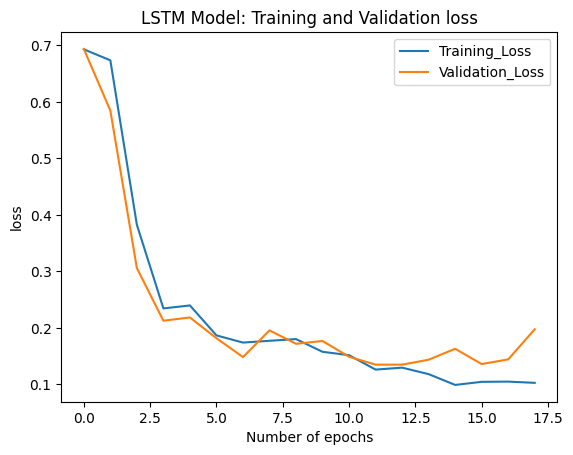

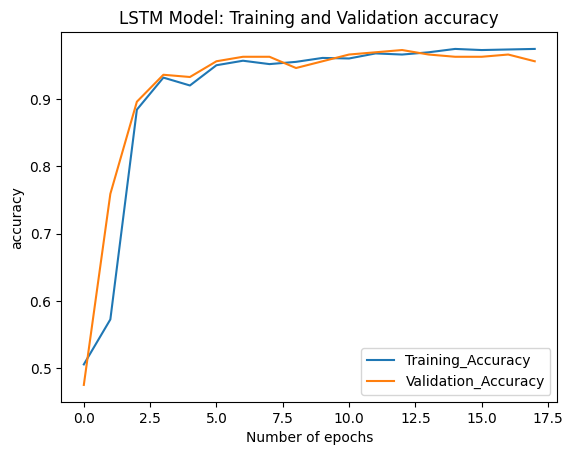

In [34]:
# Create a dataframe
metrics = pd.DataFrame(history.history)# Rename column
metrics.rename(columns = {'loss': 'Training_Loss', 'accuracy': 'Training_Accuracy',
                         'val_loss': 'Validation_Loss', 'val_accuracy': 'Validation_Accuracy'}, inplace = True)
def plot_graphs1(var1, var2, string):
    metrics[[var1, var2]].plot()
    plt.title('LSTM Model: Training and Validation ' + string)
    plt.xlabel ('Number of epochs')
    plt.ylabel(string)
    plt.legend([var1, var2])
plot_graphs1('Training_Loss', 'Validation_Loss', 'loss')
plot_graphs1('Training_Accuracy', 'Validation_Accuracy', 'accuracy')

In [35]:
# Biderectional LSTM Spam detection architecture
model2 = Sequential()
model2.add(Embedding(vocab_size, embeding_dim, input_length=max_len))
model2.add(Bidirectional(LSTM(n_lstm, dropout=drop_lstm)))
model2.add(Dense(1, activation='sigmoid'))
model2.compile(loss = 'binary_crossentropy', optimizer = 'adam', metrics=['accuracy'])
# Training
num_epochs = 30
early_stop = EarlyStopping(monitor='val_loss', patience=4)
history = model2.fit(training_padded, train_labels, epochs=num_epochs, 
                    validation_data=(testing_padded, test_labels),callbacks =[early_stop], verbose=2)
model2.save('BiLSTM_Spam_Detection.keras')

Epoch 1/30
38/38 - 5s - 125ms/step - accuracy: 0.7029 - loss: 0.6579 - val_accuracy: 0.8094 - val_loss: 0.5718
Epoch 2/30
38/38 - 1s - 16ms/step - accuracy: 0.8636 - loss: 0.4441 - val_accuracy: 0.8462 - val_loss: 0.4021
Epoch 3/30
38/38 - 1s - 16ms/step - accuracy: 0.9013 - loss: 0.3036 - val_accuracy: 0.8997 - val_loss: 0.2820
Epoch 4/30
38/38 - 1s - 18ms/step - accuracy: 0.9322 - loss: 0.1991 - val_accuracy: 0.9498 - val_loss: 0.2164
Epoch 5/30
38/38 - 1s - 26ms/step - accuracy: 0.9590 - loss: 0.1438 - val_accuracy: 0.9431 - val_loss: 0.1527
Epoch 6/30
38/38 - 1s - 21ms/step - accuracy: 0.9665 - loss: 0.1188 - val_accuracy: 0.9599 - val_loss: 0.1153
Epoch 7/30
38/38 - 1s - 19ms/step - accuracy: 0.9665 - loss: 0.1255 - val_accuracy: 0.9532 - val_loss: 0.1213
Epoch 8/30
38/38 - 1s - 19ms/step - accuracy: 0.9724 - loss: 0.0974 - val_accuracy: 0.9699 - val_loss: 0.0786
Epoch 9/30
38/38 - 1s - 18ms/step - accuracy: 0.9665 - loss: 0.1019 - val_accuracy: 0.9799 - val_loss: 0.1062
Epoch 10/

In [36]:
# Biderectional LSTM Spam detection architecture
model2 = Sequential()
model2.add(Embedding(vocab_size, embeding_dim, input_length=max_len))
model2.add(Bidirectional(LSTM(n_lstm, dropout=drop_lstm)))
model2.add(Dense(1, activation='sigmoid'))
model2.compile(loss = 'binary_crossentropy', optimizer = 'adam', metrics=['accuracy'])
# Training
num_epochs = 30
early_stop = EarlyStopping(monitor='val_loss', patience=4)
history = model2.fit(training_padded, train_labels, epochs=num_epochs, 
                    validation_data=(testing_padded, test_labels),callbacks =[early_stop], verbose=2)
model2.save('BiLSTM_Spam_Detection.h5')

Epoch 1/30
38/38 - 4s - 114ms/step - accuracy: 0.7205 - loss: 0.6622 - val_accuracy: 0.7993 - val_loss: 0.5724
Epoch 2/30
38/38 - 1s - 17ms/step - accuracy: 0.8544 - loss: 0.4455 - val_accuracy: 0.8395 - val_loss: 0.4099
Epoch 3/30
38/38 - 1s - 19ms/step - accuracy: 0.8837 - loss: 0.3201 - val_accuracy: 0.8930 - val_loss: 0.2897
Epoch 4/30
38/38 - 1s - 17ms/step - accuracy: 0.9289 - loss: 0.2244 - val_accuracy: 0.9365 - val_loss: 0.1872
Epoch 5/30
38/38 - 1s - 17ms/step - accuracy: 0.9498 - loss: 0.1681 - val_accuracy: 0.9599 - val_loss: 0.1316
Epoch 6/30
38/38 - 1s - 17ms/step - accuracy: 0.9640 - loss: 0.1319 - val_accuracy: 0.9699 - val_loss: 0.1058
Epoch 7/30
38/38 - 1s - 17ms/step - accuracy: 0.9682 - loss: 0.1079 - val_accuracy: 0.9732 - val_loss: 0.0879
Epoch 8/30
38/38 - 1s - 17ms/step - accuracy: 0.9665 - loss: 0.1011 - val_accuracy: 0.9532 - val_loss: 0.1280
Epoch 9/30
38/38 - 1s - 18ms/step - accuracy: 0.9749 - loss: 0.0786 - val_accuracy: 0.9732 - val_loss: 0.0845
Epoch 10/

In [37]:
model2.evaluate(testing_padded, test_labels)

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9672 - loss: 0.1019 


[0.10770174115896225, 0.9665551781654358]

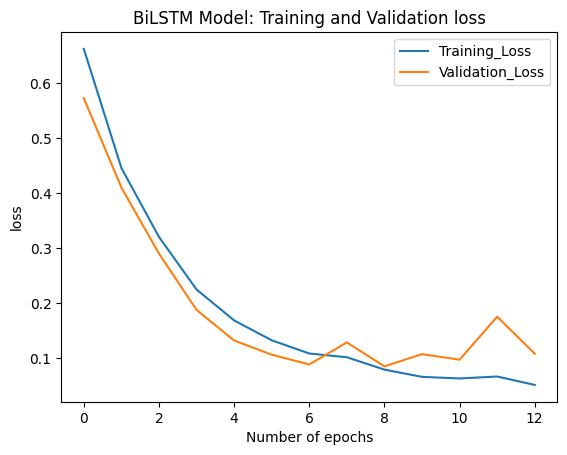

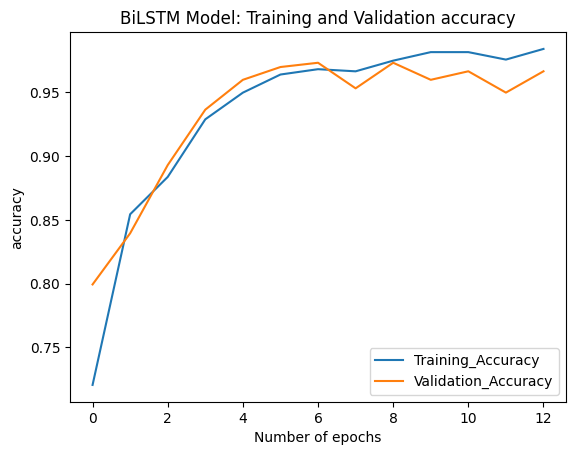

In [38]:
# Create a dataframe
metrics = pd.DataFrame(history.history)# Rename column
metrics.rename(columns = {'loss': 'Training_Loss', 'accuracy': 'Training_Accuracy',
                         'val_loss': 'Validation_Loss', 'val_accuracy': 'Validation_Accuracy'}, inplace = True)
def plot_graphs1(var1, var2, string):
    metrics[[var1, var2]].plot()
    plt.title('BiLSTM Model: Training and Validation ' + string)
    plt.xlabel ('Number of epochs')
    plt.ylabel(string)
    plt.legend([var1, var2])# Plot
plot_graphs1('Training_Loss', 'Validation_Loss', 'loss')
plot_graphs1('Training_Accuracy', 'Validation_Accuracy', 'accuracy')

In [39]:
import string
from matplotlib.gridspec import GridSpec

import re
from bs4 import BeautifulSoup
from collections import Counter

import nltk
from nltk.tokenize import word_tokenize
from nltk.stem import SnowballStemmer
from nltk.corpus import stopwords

import time
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier, RandomForestClassifier, ExtraTreesClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, balanced_accuracy_score, accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from sklearn.model_selection import cross_val_score
from sklearn.utils.multiclass import unique_labels

In [40]:
messages.duplicated().sum()

403

In [41]:
# Drop Duplicates
messages.drop_duplicates(inplace = True)

In [42]:
messages.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5169 entries, 0 to 5571
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   label    5169 non-null   object
 1   message  5169 non-null   object
dtypes: object(2)
memory usage: 121.1+ KB


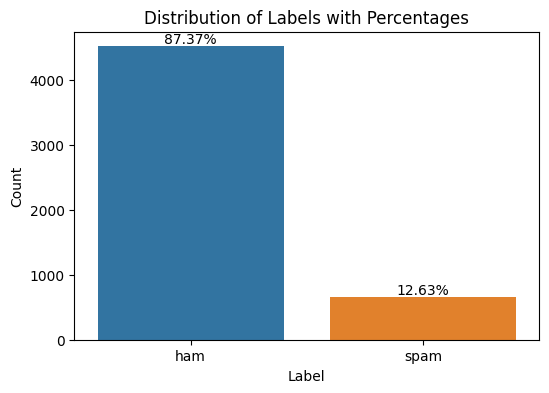

In [43]:
# Plot the value counts of 'label' with percentage inside bars
plt.figure(figsize=(6, 4))  # Adjust the figure size if needed
ax = sns.countplot(data=messages, x='label')

# Calculate percentage and annotate bars with percentages
total = float(len(messages['label']))
for p in ax.patches:
    height = p.get_height()
    ax.annotate(f'{(height/total)*100:.2f}%', (p.get_x() + p.get_width() / 2., height),
                ha='center', va='bottom', fontsize=10, color='black')

# Add labels and title
plt.xlabel('Label')
plt.ylabel('Count')
plt.title('Distribution of Labels with Percentages')

# Show the plot
plt.show()

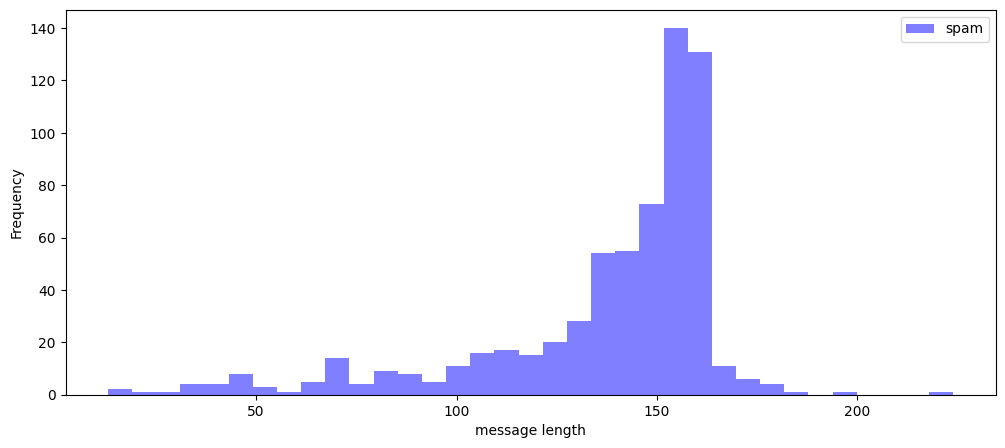

In [44]:
messages['message_length'] = messages['message'].apply(len)
messages.head()

plt.figure(figsize=(12,5))
messages[messages['label']=='spam']['message_length'].plot(bins=35,kind='hist',color='blue',label='spam',alpha=0.5)
plt.legend()
plt.xlabel('message length')
plt.show()

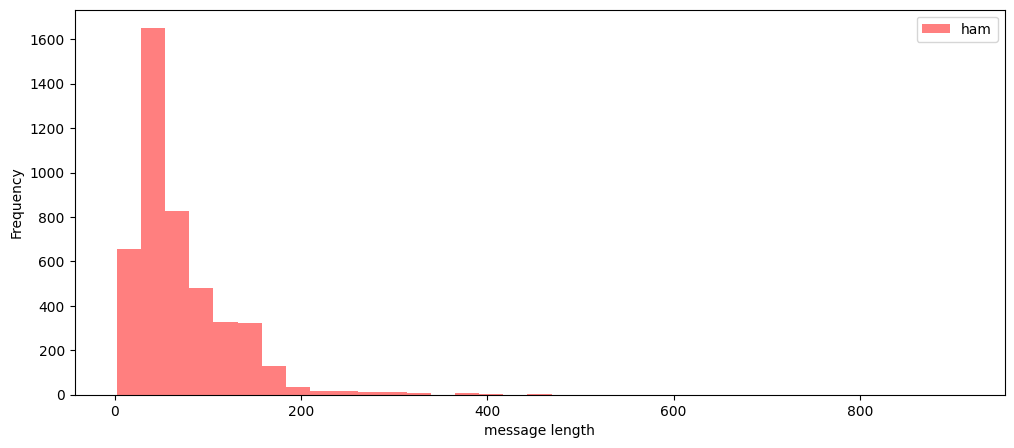

In [45]:
plt.figure(figsize=(12,5))
messages[messages['label']=='ham']['message_length'].plot(bins=35,kind='hist',color='red',label='ham',alpha=0.5)
plt.legend()
plt.xlabel('message length')
plt.show()

In [46]:
# Convert Labels into numerical
messages.label.replace("ham",0,inplace = True)
messages.label.replace("spam",1,inplace = True)
messages['label'].value_counts()

0    4516
1     653
Name: label, dtype: int64

In [47]:
stop = set(stopwords.words('english'))
punctuation = list(string.punctuation)
stop.update(punctuation)

In [48]:
# Removing the HTML Tags
def strip_html(text):
    soup = BeautifulSoup(text, "html.parser")
    return soup.get_text()

# Removing the square brackets
def remove_between_square_brackets(text):
    return re.sub('\[[^]]*\]', '', text)

# Removing URL's
def remove_between_square_brackets(text):
    return re.sub(r'http\S+', '', text)

# Removing the stopwords from text
def remove_stopwords(text):
    final_text = []
    for i in text.split():
        if i.strip().lower() not in stop:
            if i.strip().isalpha():
                final_text.append(i.strip())
    return " ".join(final_text)

# Create Master Function 
def denoise_text(text):
    text = strip_html(text)
    text = remove_stopwords(text)
    text = remove_stopwords(text)
    return text

In [49]:
messages['clean_message']=messages['message'].apply(denoise_text)
messages.head(2)

,label,message,message_length,clean_message
0,0,"Go until jurong point, crazy.. Available only ...",111,Go jurong Available bugis n great world la e C...
1,0,Ok lar... Joking wif u oni...,29,Ok Joking wif u


In [50]:
# Initialize Snowball Stemmer
snowball_stemmer = SnowballStemmer('english')

# Preprocessing
preprocessed_messages = []

for _, row in messages.iterrows():
    review = re.sub('[^a-zA-Z]', ' ', row['message'])
    review = review.lower()
    tokens = word_tokenize(review)
    tokens = [snowball_stemmer.stem(word) for word in tokens if not word in stopwords.words('english')]
    preprocessed_review = ' '.join(tokens)
    preprocessed_messages.append(preprocessed_review)

# Add preprocessed messages back to the DataFrame
messages['clean_message'] = messages['clean_message']

# Display the preprocessed DataFrame
messages

,label,message,message_length,clean_message
0,0,"Go until jurong point, crazy.. Available only ...",111,Go jurong Available bugis n great world la e C...
1,0,Ok lar... Joking wif u oni...,29,Ok Joking wif u
2,1,Free entry in 2 a wkly comp to win FA Cup fina...,155,Free entry wkly comp win FA Cup final tkts May...
3,0,U dun say so early hor... U c already then say...,49,U dun say early U c already
4,0,"Nah I don't think he goes to usf, he lives aro...",61,Nah think goes lives around though
...,...,...,...,...
5567,1,This is the 2nd time we have tried 2 contact u...,161,time tried contact U Pound claim call per
5568,0,Will Ì_ b going to esplanade fr home?,37,b going esplanade fr
5569,0,"Pity, * was in mood for that. So...any other s...",57,mood
5570,0,The guy did some bitching but I acted like i'd...,125,guy bitching acted like interested buying some...


In [51]:
# Add a new column 'clean_message_length'
messages['clean_message_length'] = messages['clean_message'].apply(len)
messages

,label,message,message_length,clean_message,clean_message_length
0,0,"Go until jurong point, crazy.. Available only ...",111,Go jurong Available bugis n great world la e C...,59
1,0,Ok lar... Joking wif u oni...,29,Ok Joking wif u,15
2,1,Free entry in 2 a wkly comp to win FA Cup fina...,155,Free entry wkly comp win FA Cup final tkts May...,78
3,0,U dun say so early hor... U c already then say...,49,U dun say early U c already,27
4,0,"Nah I don't think he goes to usf, he lives aro...",61,Nah think goes lives around though,34
...,...,...,...,...,...
5567,1,This is the 2nd time we have tried 2 contact u...,161,time tried contact U Pound claim call per,41
5568,0,Will Ì_ b going to esplanade fr home?,37,b going esplanade fr,20
5569,0,"Pity, * was in mood for that. So...any other s...",57,mood,4
5570,0,The guy did some bitching but I acted like i'd...,125,guy bitching acted like interested buying some...,79


In [52]:
# Creating independent & dependent variable 
X = messages['clean_message']
y = messages['label']

In [53]:
# Convert text into vectors using TF-IDF
tf = TfidfVectorizer()
tfTrainReviews = tf.fit_transform(X)
tfTrainReviews

<5169x6012 sparse matrix of type '<class 'numpy.float64'>'
	with 30663 stored elements in Compressed Sparse Row format>

In [54]:
tfTrainReviews.toarray()

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [55]:
# Get the feature names (words)
feature_names = tf.get_feature_names_out()

# Convert the TF-IDF matrix to a DataFrame for better visualization
tfidf_df = pd.DataFrame(tfTrainReviews.toarray(), columns=feature_names)

# Display the TF-IDF features
tfidf_df.head()

,aa,aah,aaniye,aaooooright,abdomen,abi,ability,abiola,abj,able,...,zhong,zindgi,zoe,zoom,zouk,zyada,åð,åòharry,åôrents,ìï
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [56]:
X_train, X_test, y_train, y_test = train_test_split(tfTrainReviews, y, test_size = 0.20, random_state = 42)
print("X_train shape: {}\nX_test shape: {}\nY_train shape: {}\nY_test shape: {}".format(X_train.shape,X_test.shape,y_train.shape,y_test.shape))

X_train shape: (4135, 6012)
X_test shape: (1034, 6012)
Y_train shape: (4135,)
Y_test shape: (1034,)


In [57]:
# Set random state and n_jobs
random_state = 42
n_jobs = -1

# Initialize a list of classifiers with specified parameters
classifiers = [
    LogisticRegression(random_state=random_state, n_jobs=n_jobs),
    DecisionTreeClassifier(random_state=random_state),
    KNeighborsClassifier(n_jobs=n_jobs),
    MultinomialNB(),
    AdaBoostClassifier(random_state=random_state),
    GradientBoostingClassifier(random_state=random_state),
    RandomForestClassifier(random_state=random_state, n_jobs=n_jobs),
    XGBClassifier(random_state=random_state, n_jobs=n_jobs),
    SVC(random_state=random_state)
]

results = []

# Loop through each classifier
for classifier in classifiers:
    start_time = time.time()
    
    # Train the classifier
    classifier.fit(X_train, y_train)
    
    # Predict on the training set
    y_train_pred = classifier.predict(X_train)
    
    # Predict on the test set
    y_test_pred = classifier.predict(X_test)
    
    # Calculate performance metrics for training set
    train_accuracy = np.mean(y_train_pred == y_train)
    train_report = classification_report(y_train, y_train_pred, output_dict=True)
    train_precision = train_report['weighted avg']['precision']
    train_recall = train_report['weighted avg']['recall']
    train_f1 = train_report['weighted avg']['f1-score']
    train_balanced_acc = balanced_accuracy_score(y_train, y_train_pred)
    
    # Calculate performance metrics for test set
    test_accuracy = np.mean(y_test_pred == y_test)
    test_report = classification_report(y_test, y_test_pred, output_dict=True)
    test_precision = test_report['weighted avg']['precision']
    test_recall = test_report['weighted avg']['recall']
    test_f1 = test_report['weighted avg']['f1-score']
    test_balanced_acc = balanced_accuracy_score(y_test, y_test_pred)
    
    # Calculate the time taken for training
    build_time = time.time() - start_time
    
    # Append results to the list
    results.append([classifier.__class__.__name__, train_accuracy, train_precision, train_recall, train_f1, train_balanced_acc, 
                    test_accuracy, test_precision, test_recall, test_f1, test_balanced_acc, build_time])

# Create a DataFrame from the results
columns = ["Algorithm", 
           "Train Accuracy", "Train Precision", "Train Recall", "Train F1-score", "Train Balanced Accuracy",
           "Test Accuracy", "Test Precision", "Test Recall", "Test F1-score", "Test Balanced Accuracy",
           "Building Time (s)"]

results_df = pd.DataFrame(results, columns=columns)

# Print the results
print("Model Performance on Training and Test Sets")
results_df

Model Performance on Training and Test Sets


,Algorithm,Train Accuracy,Train Precision,Train Recall,Train F1-score,Train Balanced Accuracy,Test Accuracy,Test Precision,Test Recall,Test F1-score,Test Balanced Accuracy,Building Time (s)
0,LogisticRegression,0.954776,0.955225,0.954776,0.950952,0.826102,0.935203,0.934101,0.935203,0.929193,0.792052,1.327714
1,DecisionTreeClassifier,0.999516,0.999517,0.999516,0.999516,0.998031,0.937137,0.936958,0.937137,0.937046,0.868209,1.242894
2,KNeighborsClassifier,0.923337,0.929499,0.923337,0.907559,0.687992,0.906190,0.915418,0.906190,0.885042,0.665517,0.722806
3,MultinomialNB,0.961064,0.962719,0.961064,0.957821,0.841535,0.951644,0.953593,0.951644,0.947484,0.830472,0.008336
4,AdaBoostClassifier,0.969045,0.968535,0.969045,0.967859,0.893483,0.949710,0.948035,0.949710,0.947596,0.858206,2.154953
5,GradientBoostingClassifier,0.968319,0.968925,0.968319,0.966438,0.875295,0.953578,0.953566,0.953578,0.950564,0.848912,6.458718
6,RandomForestClassifier,0.999516,0.999517,0.999516,0.999516,0.998031,0.965184,0.965778,0.965184,0.963332,0.881634,1.670742
7,XGBClassifier,0.983797,0.984042,0.983797,0.983315,0.934902,0.964217,0.963422,0.964217,0.963507,0.907044,0.292675
8,SVC,0.994438,0.994458,0.994438,0.994387,0.978209,0.964217,0.964258,0.964217,0.962516,0.883957,1.247821


In [58]:
# Initialize Random Forest Classifier
random_forest_classifier = RandomForestClassifier(random_state=42, n_jobs=-1)

# Train the classifier
random_forest_classifier.fit(X_train, y_train)

RandomForestClassifier(n_jobs=-1, random_state=42)

In [59]:
# Predict on the train set
y_train_pred = random_forest_classifier.predict(X_train)

# Predict on the test set
y_test_pred = random_forest_classifier.predict(X_test)

# Calculate performance metrics for training set
train_report = classification_report(y_train, y_train_pred, output_dict=True)
train_accuracy = train_report['accuracy']
train_precision = train_report['weighted avg']['precision']
train_recall = train_report['weighted avg']['recall']
train_f1 = train_report['weighted avg']['f1-score']
train_balanced_acc = balanced_accuracy_score(y_train, y_train_pred)

# Calculate performance metrics for test set
test_report = classification_report(y_test, y_test_pred, output_dict=True)
test_accuracy = test_report['accuracy']
test_precision = test_report['weighted avg']['precision']
test_recall = test_report['weighted avg']['recall']
test_f1 = test_report['weighted avg']['f1-score']
test_balanced_acc = balanced_accuracy_score(y_test, y_test_pred)

# Create a DataFrame to store results
results_df = pd.DataFrame({
    'Metric': ['Accuracy', 'Precision', 'Recall', 'F1-score', 'Balanced Accuracy'],
    'Train': [train_accuracy, train_precision, train_recall, train_f1, train_balanced_acc],
    'Test': [test_accuracy, test_precision, test_recall, test_f1, test_balanced_acc]
})

# Print the results DataFrame
results_df

,Metric,Train,Test
0,Accuracy,0.999516,0.965184
1,Precision,0.999517,0.965778
2,Recall,0.999516,0.965184
3,F1-score,0.999516,0.963332
4,Balanced Accuracy,0.998031,0.881634


In [60]:
# Generate classification report for training data
train_report = classification_report(y_train, y_train_pred)
print("Classification Report for Training Data:\n", train_report)

print('-'*127)

# Generate classification report for test data
test_report = classification_report(y_test, y_test_pred)
print("Classification Report for Test Data:\n", test_report)

Classification Report for Training Data:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00      3627
           1       1.00      1.00      1.00       508

    accuracy                           1.00      4135
   macro avg       1.00      1.00      1.00      4135
weighted avg       1.00      1.00      1.00      4135

-------------------------------------------------------------------------------------------------------------------------------
Classification Report for Test Data:
               precision    recall  f1-score   support

           0       0.96      1.00      0.98       889
           1       0.98      0.77      0.86       145

    accuracy                           0.97      1034
   macro avg       0.97      0.88      0.92      1034
weighted avg       0.97      0.97      0.96      1034



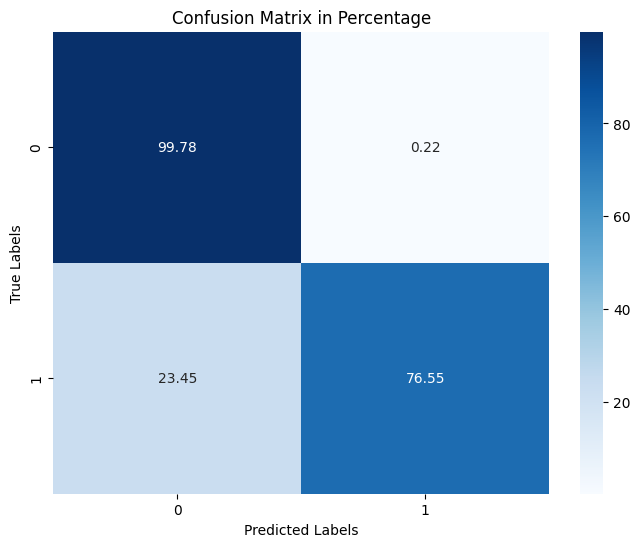

In [61]:
# Generate confusion matrix
cm = confusion_matrix(y_test, y_test_pred)

# Calculate percentages
cm_percent = (cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]) * 100

# Get class labels
class_labels = unique_labels(y_test, y_test_pred)

# Create a heatmap of the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm_percent, annot=True, fmt=".2f", cmap="Blues", xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix in Percentage')
plt.show()

In [62]:
#cross validation of Recall
from sklearn.model_selection import cross_val_score
scores = cross_val_score(random_forest_classifier, X_train, y_train, cv=5, scoring='accuracy',n_jobs=-1)

print("Cross-Validation Scores (Accuracy):", scores)
print()
print("Mean Accuracy Score:", scores.mean())

Cross-Validation Scores (Accuracy): [0.95888755 0.96130593 0.9637243  0.96614268 0.96735187]

Mean Accuracy Score: 0.9634824667472792


In [63]:
import joblib
model = random_forest_classifier
joblib.dump(model, 'Ham_Vs_Spam_Classifier.pkl')

['Ham_Vs_Spam_Classifier.pkl']